<a href="https://colab.research.google.com/github/samsoe/mpg_notebooks/blob/master/abundance_order_habitat_wrangle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# View: abundance_order_habitat
Project:Dataset in BQ: **mpg-data-warehouse:bird_point_count_summaries**

This view will allow us to analyze basic trends in bird abundance among habitats at MPG. Initially, such summaries are necessary for the MPG Matrix. To produce the view, the bird data must first be summarized to obtain abundances by taxonomic order at each grid point. There will be several steps to consider how to account for the number of technician visits per year and the number of points visited per year. Then, the summarized bird data will be joined to a habitat classification from grid point metadata.

* Documentation: [Readme bird point count monitoring](https://docs.google.com/document/d/1PRryJzGOUtfr-fKXzb3tbr48xiaTuAMVk18XFXlvxcM/edit?usp=sharing)

## Updates will be necessary
* **2020-05-22**. Right now, this file must pull data from a csv in GD, rather than a view in BQ as intended. This is due to an [OAuth issue](https://colab.research.google.com/drive/1NkqB9RXRpMl2m4fwTy3H5rz1SDwCA_DE#scrollTo=EIn9rVWbwOMo&line=1&uniqifier=1) that we are looking into. Make sure that we evenually circle back and confirm that this notebook is pulling data from BQ, whether we have to flatten the source files, or if we learn how to manage GD OAuth.
* **2020-05-22**. Right now, abundance summaries for the MPG Matrix are processed in this notebook. Once we are able to solve the issue from (1), move the abundance summaires to a new notebook located in the Matrix directory. 

## Security
* The user must load a `json` file containing the BigQuery API key into the local directory `/content/...`
* The user must have a Google Maps API key to enable mapping. 
   * CAUTION make sure the key is deleted from the current instance of the notebook before sharing

# Tools
* Remember that the file containing authorization keys for Big Query must be loaded into the virutual envrionment manually.

In [0]:
library(tidyverse)
library(knitr)
library(repr)
library(colorspace)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [0]:
install.packages("bigrquery")
library(bigrquery)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bit’, ‘bit64’, ‘gargle’, ‘rapidjsonr’




In [0]:
# remove.packages("ggmap") 

In [0]:
if(!requireNamespace("devtools")) install.packages("devtools")
devtools::install_github("dkahle/ggmap", ref = "tidyup", force=TRUE)
# mapping
library("ggmap")

Loading required namespace: devtools




ggplot2     (3.3.0 -> 3.3.1  ) [CRAN]
RgoogleMaps (NA    -> 1.4.5.3) [CRAN]
png         (NA    -> 0.1-7  ) [CRAN]
rjson       (NA    -> 0.2.20 ) [CRAN]
jpeg        (NA    -> 0.1-8.1) [CRAN]
dplyr       (0.8.5 -> 1.0.0  ) [CRAN]
bitops      (NA    -> 1.0-6  ) [CRAN]
pkgload     (1.0.2 -> 1.1.0  ) [CRAN]
rprojroot   (1.2   -> 1.3-2  ) [CRAN]
processx    (3.4.1 -> 3.4.2  ) [CRAN]
farver      (2.0.1 -> 2.0.3  ) [CRAN]
sp          (NA    -> 1.4-2  ) [CRAN]
curl        (4.2   -> 4.3    ) [CRAN]


Installing 13 packages: ggplot2, RgoogleMaps, png, rjson, jpeg, dplyr, bitops, pkgload, rprojroot, processx, farver, sp, curl

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



✔  checking for file ‘/tmp/Rtmp2OklUM/remotes7b12182f78/dkahle-ggmap-2d756e5/DESCRIPTION’
─  preparing ‘ggmap’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
   Removed empty directory ‘ggmap/.github’
─  looking to see if a ‘data/datalist’ file should be added
─  building ‘ggmap_3.0.0.tar.gz’ (603ms)
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Google's Terms of Service: https://cloud.google.com/maps-platform/terms/.

Please cite ggmap if you use it! See citation("ggmap") for details.



In [0]:
#@title Google Maps API key { vertical-output: true }
#@markdown Remember to delete the key from the input field 
#@markdown before sharing this file. Preferably, delete after 
#@markdown running this code and successfully authenticating.
key <- "" #@param {type:"string"}
register_google(key = key)
has_google_key()

[1] TRUE

## Functions and Styles
* Theme BGL for ggplot

In [0]:
# Theme BGL
# ————————————————————

theme_bgl = 
    theme_bw() +
    theme(
        axis.title = element_text(
            size = 12,
            family = "serif",
            face = 1
        ),
        axis.text.x = element_text(
            size = 9,
            family = "serif",
            face = 2,
            margin = unit(c(
                t = 3,
                r = 0,
                o = 0,
                b = 0
            ), "mm")
        ),
        axis.text.y = element_text(
            size = 9,
            family = "serif",
            face = 2,
            margin = unit(c(
                t = 0,
                r = 3,
                o = 0,
                b = 0
            ), "mm")
        ),
        axis.ticks.length = unit(-2, "mm"),
        strip.text = element_text(
            size = 12,
            family = "serif",
            face = 2
        ),
        plot.caption = element_text(
            size = 8,
            family = "serif",
            face = 2
        ),
        plot.title = element_text(
            size = 14,
            family = "serif",
            face = 2
        ),
        text = element_text(family = "serif"),
        legend.text = element_text(
            size = 12,
            family = "serif",
            face = 1
        ),
        legend.title = element_text(
            size = 12,
            family = "serif",
            face = 1
        ),
        legend.position = "right",
        panel.grid = element_blank()
    ) 



# Source

## BigQuery

### Database Connection

In [0]:
# BigQuery API Key
bq_auth(path = "/content/mpg-data-warehouse-api_key-master.json")

In [0]:
Sys.setenv(BIGQUERY_TEST_PROJECT = "mpg-data-warehouse")

In [0]:
billing <- bq_test_project()

In [0]:
con_bird_point_counts <- dbConnect(
  bigrquery::bigquery(),
  project = "mpg-data-warehouse",
  dataset = "bird_point_counts",
  billing = billing
)

In [0]:
con_location_position_classification <- dbConnect(
    bigrquery::bigquery(),
  project = "mpg-data-warehouse",
  dataset = "grid_point_summaries",
  billing = billing
)

In [0]:
dbListTables(con_bird_point_counts)

[1] "bird_surveyInfo_records_function" "bird_survey_noise"               
[3] "bird_survey_sky"                  "bird_survey_wind"

In [0]:
dbListTables(con_location_position_classification)

[1] "location"                         "location_position_classification"
[3] "point_location_position"

### Query Database

#### bird_point_counts

In [0]:
bird_sql <- "SELECT *
             FROM `mpg-data-warehouse.bird_point_counts.bird_surveyInfo_records_function`"

In [0]:
# result bird table
bq_bird <- bq_project_query(billing, bird_sql)

In [0]:
tb_bird = bq_table_download(bq_bird)

In [0]:
class(tb_bird)

[1] "tbl_df"     "tbl"        "data.frame"

In [0]:
df_bird <- as.data.frame(tb_bird)

In [0]:
str(df_bird)

'data.frame':	117810 obs. of  31 variables:
 $ survey_ID                         : int  4915 4915 4915 4915 4915 4915 4915 4915 4915 4915 ...
 $ survey_year                       : int  2013 2013 2013 2013 2013 2013 2013 2013 2013 2013 ...
 $ survey_date                       : Date, format: "2013-06-17" "2013-06-17" ...
 $ survey_visit_calc                 : int  2 2 2 2 2 2 2 2 2 2 ...
 $ survey_time_start_MDT             : 'hms' num  08:27:00 08:27:00 08:27:00 08:27:00 ...
  ..- attr(*, "units")= chr "secs"
 $ survey_time_end_MDT               : 'hms' num  08:37:00 08:37:00 08:37:00 08:37:00 ...
  ..- attr(*, "units")= chr "secs"
 $ survey_grid_point                 : int  179 179 179 179 179 179 179 179 179 179 ...
 $ survey_observer                   : chr  "Katharine Stone" "Katharine Stone" "Katharine Stone" "Katharine Stone" ...
 $ survey_wind_code                  : int  3 3 3 3 3 3 3 3 3 3 ...
 $ survey_sky_code                   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ survey_noise

#### location_position_classification

In [0]:
location_sql <- "SELECT *
                 FROM `mpg-data-warehouse.grid_point_summaries.location_position_classification`"

Leave the following error for now.  To move forward in the present output csv from table `mpg-data-warehouse.grid_point_summaries.location_position_classification`

In [0]:
# bq_location <- bq_project_query(billing, location_sql)

## CSV

### location_position_classification

In [0]:
# MPG Ranch Datasets > Bird point count monitoring > Data - Processed > location_position_classification.csv
src_location = "https://drive.google.com/uc?id=1z1nFdsk0vZXhw78rB3ijrFcLX2mF4VBQ"
df_location <- read_csv(src_location)

Parsed with column specification:
cols(
  grid_point = col_double(),
  lat = col_double(),
  long = col_double(),
  aspect_mean_deg = col_double(),
  elevation_mean_m = col_double(),
  slope_mean_deg = col_double(),
  cover_type_2016_gridVeg = col_character(),
  biomass_habitat_type = col_character(),
  type1_biome = col_character(),
  type2_vegetation_community = col_character(),
  type3_vegetation_indicators = col_character(),
  type4_indicators_history = col_character()
)



# Structure

## bird_point_counts
In general, make sure any user is familiar with the data entry protocol before summarizing these data. Many grouping and summarizing steps are often necessary to properly examine these data. 

* When correcting for survey effort, we need to divide the annual sums by the number of survey visits. In almost all cases, visits = 2, so dividing by 2 is probably sufficient. However, a more robust approach would be to create a "total visits" variable and use that to calculate averages. This is the approach we used.
* There are 218 missing records in `function_taxa_order` that result from the bird records summary below. They result from the various "unknown bird" designations possible in the species list, and are acceptable to disregard. 
* There are 21 missing records in `records_abundance`, but these are eliminated using the sum() function in the first summary. 
* 2020-05-25 BL performed a quick diagnostic to test the summary produced here. The number of grid points surveyed per year matched what was found in the wrangle notebook [here](https://colab.research.google.com/drive/1iOF9P-cfzE4-A7KA2M3xJ7zXmSZnuUSe#scrollTo=kSANOTDWLRgU&line=8&uniqifier=1), which is some supporting evidence that all data were recovered in this summary. 

In [0]:
# Total visits per year
df_visits <-
  df_bird %>% 
  group_by(survey_year, survey_grid_point) %>% 
  summarize(survey_visits_total = max(survey_visit_calc)) %>% glimpse()

Rows: 4,157
Columns: 3
Groups: survey_year [10]
$ survey_year         <int> 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2…
$ survey_grid_point   <int> 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 1…
$ survey_visits_total <int> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2…


In [0]:
# Abundance summary
bird_abundance <- df_bird %>%
  filter(records_detect_distance_min_meters <= 100,
         records_interval %in% c(1, 2), 
         !(records_location_code %in% c("F", "U"))) %>%
  group_by(survey_year, survey_visit_calc, survey_grid_point, function_taxa_order) %>%
  summarize(bird_abundance_survey = sum(records_abundance, na.rm = TRUE)) %>%
  group_by(survey_year, survey_grid_point, function_taxa_order) %>%
  summarize(bird_abundance_sum = sum(bird_abundance_survey, na.rm = TRUE)) %>%
  ungroup() %>%  
  left_join(df_visits) %>% 
  drop_na() %>%
  mutate(bird_abundance_avg = bird_abundance_sum / survey_visits_total) %>% 
  select(-survey_visits_total, -bird_abundance_sum) %>% 
  glimpse()

Joining, by = c("survey_year", "survey_grid_point")



Rows: 6,748
Columns: 4
$ survey_year         <int> 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2…
$ survey_grid_point   <int> 1, 1, 2, 2, 3, 3, 4, 6, 7, 7, 8, 8, 9, 9, 10, 11,…
$ function_taxa_order <chr> "Galliformes", "Passeriformes", "Galliformes", "P…
$ bird_abundance_avg  <dbl> 0.5, 17.0, 1.0, 7.0, 0.5, 8.0, 5.5, 7.5, 0.5, 6.0…


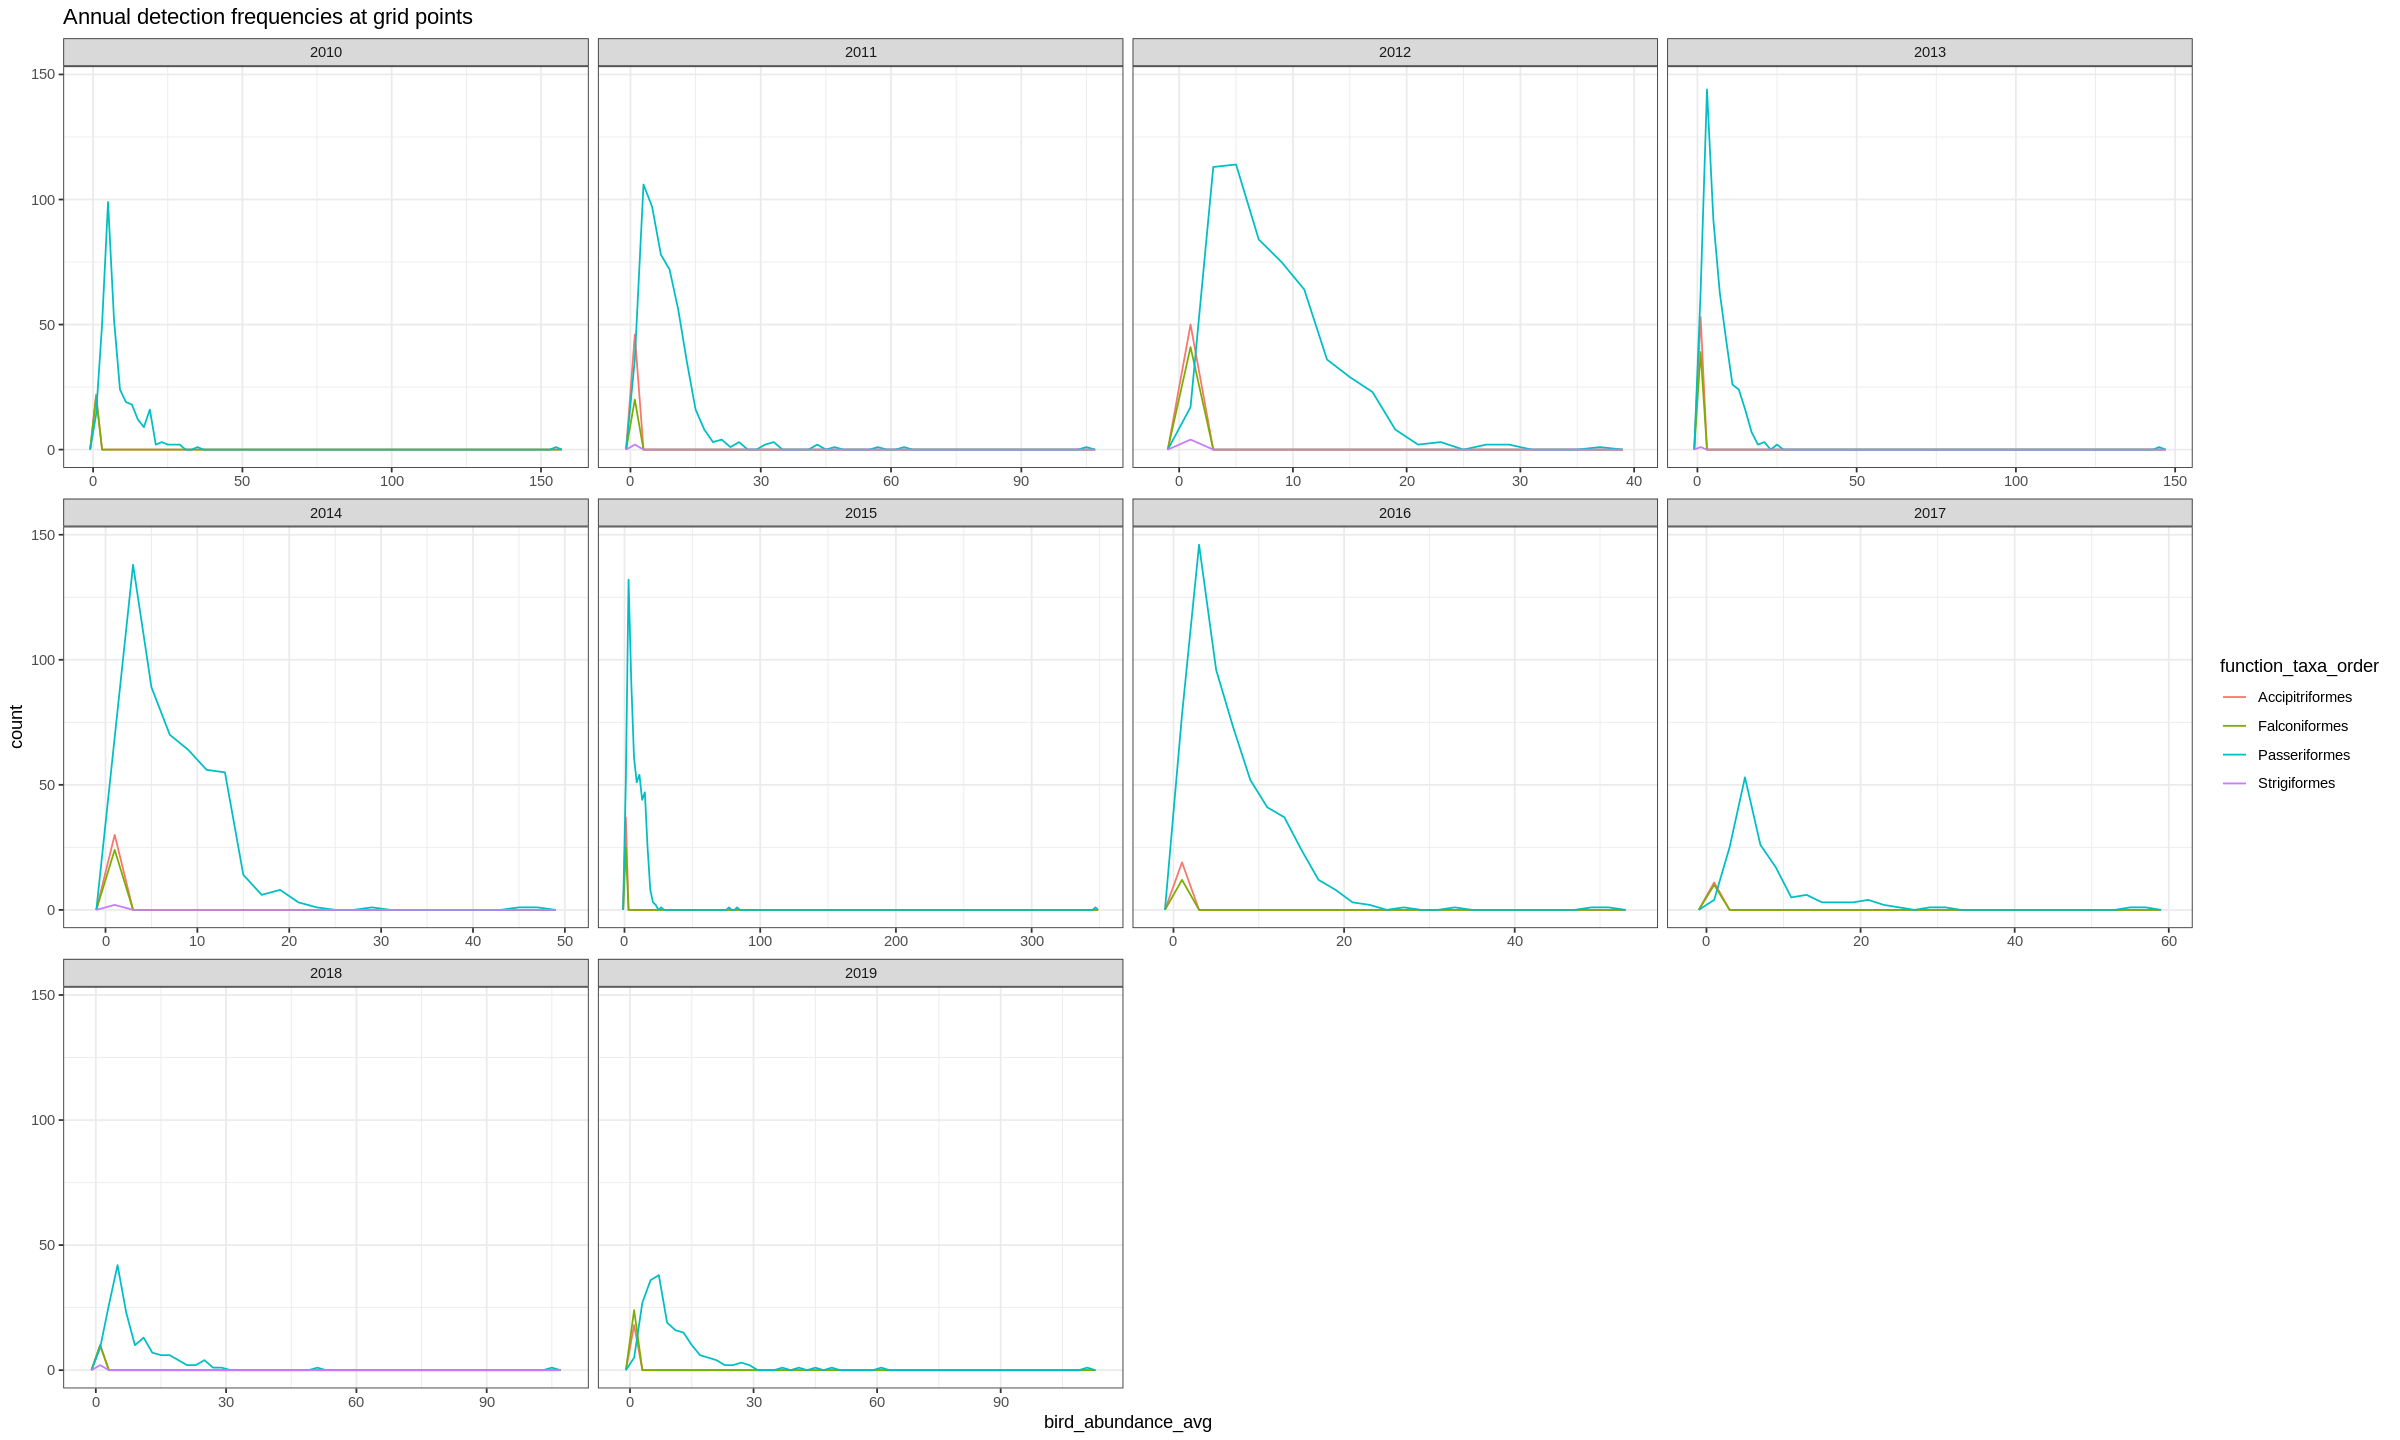

In [0]:
options(repr.plot.width = 20, repr.plot.height = 12)
bird_abundance %>% 
filter(function_taxa_order %in% c("Passeriformes", "Accipitriformes", "Falconiformes", "Strigiformes")) %>% 
ggplot(aes(x = bird_abundance_avg)) +
geom_freqpoly(aes(color = function_taxa_order), center = 1, binwidth = 2) +
facet_wrap(vars(survey_year), scales = "free_x") +
labs(title = "Annual detection frequencies at grid points") +
theme_bw()
# Abundances > 100 are Bank Swallows and European Starlings

# Join tables
Join **grid point metadata** and **bird records** with selected columns to produce the desired view: **abundance_order_habitat**

* 2020-05-22 BL initial diagnostics on this look good




In [0]:
bird_abundance %>% 
glimpse()

Rows: 6,748
Columns: 4
$ survey_year         <int> 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2…
$ survey_grid_point   <int> 1, 1, 2, 2, 3, 3, 4, 6, 7, 7, 8, 8, 9, 9, 10, 11,…
$ function_taxa_order <chr> "Galliformes", "Passeriformes", "Galliformes", "P…
$ bird_abundance_avg  <dbl> 0.5, 17.0, 1.0, 7.0, 0.5, 8.0, 5.5, 7.5, 0.5, 6.0…


In [0]:
df_location %>% 
glimpse()

Rows: 582
Columns: 12
$ grid_point                  <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…
$ lat                         <dbl> 46.73193, 46.72972, 46.72443, 46.72487, 4…
$ long                        <dbl> -114.0017, -114.0010, -114.0227, -114.019…
$ aspect_mean_deg             <dbl> 334.7050, 45.3030, 221.3340, 290.4890, 28…
$ elevation_mean_m            <dbl> 1395.64, 1456.09, 1126.90, 1166.33, 1179.…
$ slope_mean_deg              <dbl> 28.44230, 12.22630, 4.25130, 2.68361, 4.2…
$ cover_type_2016_gridVeg     <chr> "woodland/forest", "non-irrigated grassla…
$ biomass_habitat_type        <chr> NA, "Range", "Range", "Range", "Range", "…
$ type1_biome                 <chr> "forest", "rangeland", "rangeland", "rang…
$ type2_vegetation_community  <chr> "upland", "grassland", "grassland", "gras…
$ type3_vegetation_indicators <chr> "mixed canopy conifer", "uncultivated gra…
$ type4_indicators_history    <chr> "mixed canopy conifer", "uncultivated gra…


In [0]:
# Create the desired table for view
abundance_order_habitat <-
bird_abundance %>% 
  left_join(df_location %>% select(grid_point, starts_with("cover"), starts_with("biomass"), starts_with("type")), 
            by = c("survey_grid_point" = "grid_point")) %>%
  glimpse()

Rows: 6,748
Columns: 10
$ survey_year                 <int> 2010, 2010, 2010, 2010, 2010, 2010, 2010,…
$ survey_grid_point           <dbl> 1, 1, 2, 2, 3, 3, 4, 6, 7, 7, 8, 8, 9, 9,…
$ function_taxa_order         <chr> "Galliformes", "Passeriformes", "Gallifor…
$ bird_abundance_avg          <dbl> 0.5, 17.0, 1.0, 7.0, 0.5, 8.0, 5.5, 7.5, …
$ cover_type_2016_gridVeg     <chr> "woodland/forest", "woodland/forest", "no…
$ biomass_habitat_type        <chr> NA, NA, "Range", "Range", "Range", "Range…
$ type1_biome                 <chr> "forest", "forest", "rangeland", "rangela…
$ type2_vegetation_community  <chr> "upland", "upland", "grassland", "grassla…
$ type3_vegetation_indicators <chr> "mixed canopy conifer", "mixed canopy con…
$ type4_indicators_history    <chr> "mixed canopy conifer", "mixed canopy con…


# Matrix Output
For the MPG Matrix, the `abundance_order_habitat` table is restricted to the four orders "Passeriformes", "Accipitriformes", "Falconiformes", and "Strigiformes". Then, it is restricted to *rangeland* habitat types. Then, zeroes are filled in for any grid points where the bird orders were not found so that we obtain an average of these birds across all grid points. Two abundance summaries are produced:
* *Matrix Quantiles* for spatial data for each year, averaging quantiles across years
* *Matrix Quantiles* for averaged abundances for each year

*Matrix Quantiles* were defined by Dean Pearson and Phil Hahn, as of 2020-05-27 the quantiles are c(min, 0.33, 0.50, mean, 0.66, max)

Before producing these summary data, let's have a quick look at survey effort over time in the habitats that are useful for the Matrix to make sure we aren't including inappropriate data.

In [0]:
#@title Potential survey effort { run: "auto", vertical-output: true, form-width: "50%" }
#@markdown 364 grid points are available in rangeland habitat
df_location %>% 
group_by(type1_biome) %>% 
summarize(points = n()) %>% 
kable(format = "pandoc", 
      caption = "grid points available in habitats")



Table: grid points available in habitats

type1_biome    points
------------  -------
forest            206
rangeland         364
NA                 12

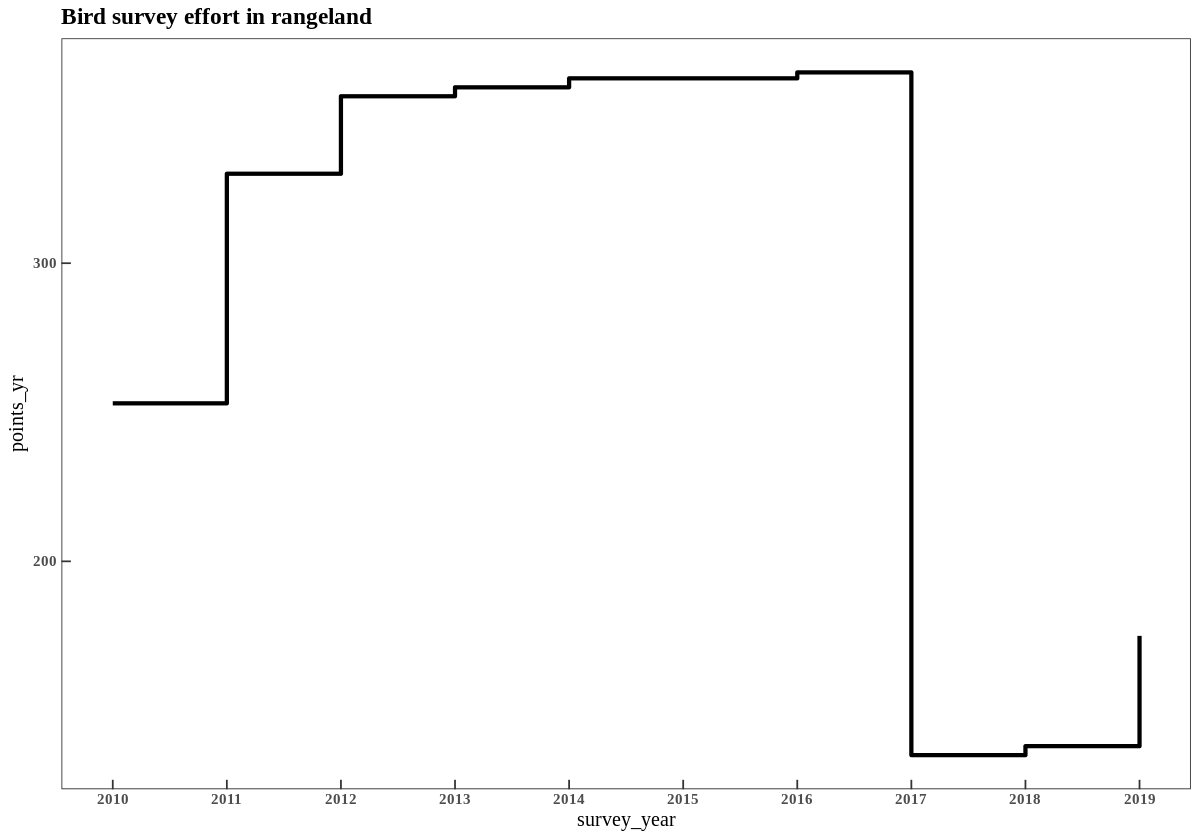

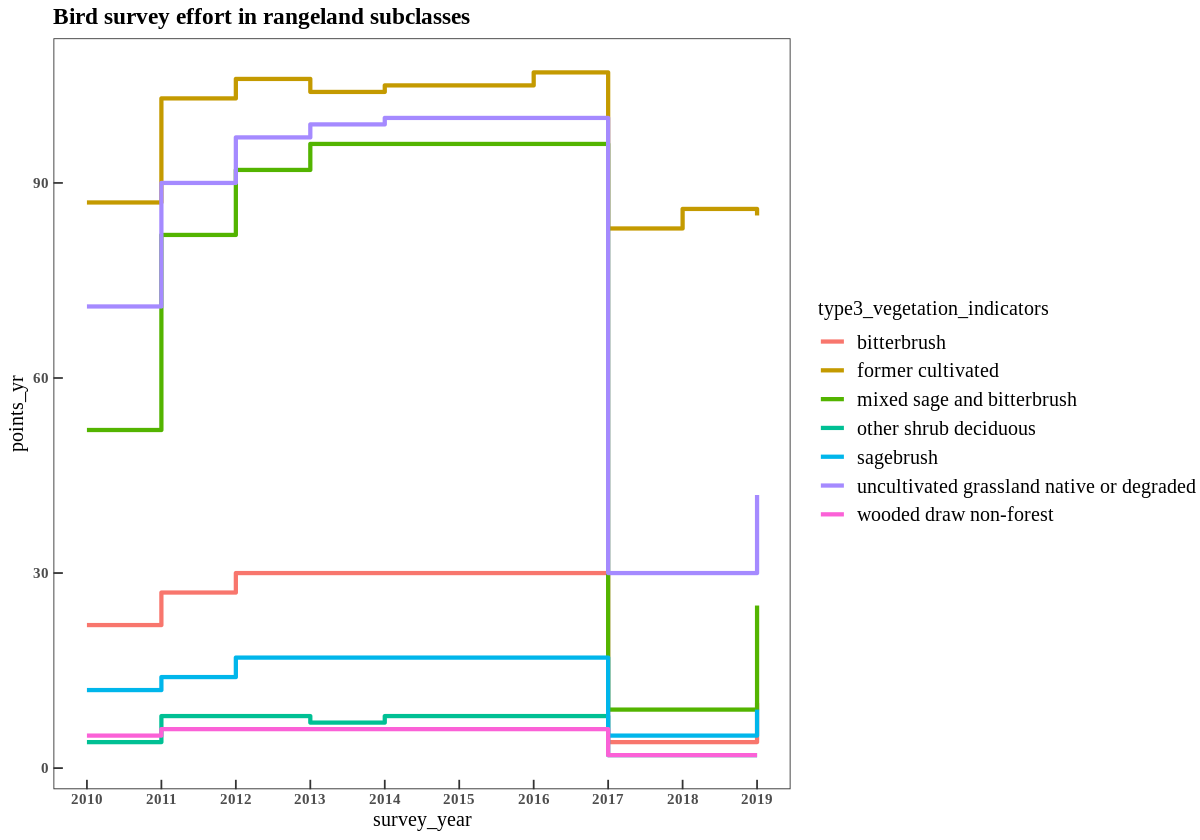

In [0]:
#@title Actual survey effort { run: "auto", vertical-output: true, form-width: "50%" }
#@markdown Survey effort was inconsistent over the years, 
#@markdown with 2010-2011 and 2017-2019 having fewer surveys.
#@markdown The number of surveys conducted in those years is
#@markdown likely still sufficient to allow quantiles calculation
#@markdown for the MPG Matrix. For other uses, the location of 
#@markdown those points should be examined to make sure they 
#@markdown won't introduce bias in bird abundance data.

#@markdown The second plot below shows the survey effort broken
#@markdown out by type 3 habitat classifications. 
#@markdown * *former cultivated* habitat type is evenly represented across years
#@markdown * *uncultivated grassland* habitat types are only sampled 
#@markdown at about 30% of total in 2017-2019, possibly unfortunate as this
#@markdown habitat is the control type for *former cultivated*
#@markdown * It looks like all shrub-based habitats were surveyed much 
#@markdown less in 2017-2019

# Control axis options
options(repr.plot.width = 10, repr.plot.height = 7)
axis_limits = range(abundance_order_habitat$survey_year)

abundance_order_habitat %>% 
filter(type1_biome == "rangeland") %>% 
group_by(survey_year, survey_grid_point) %>% 
slice(1) %>% 
group_by(survey_year, type1_biome) %>% 
summarize(points_yr = n()) %>% 
ggplot(aes(x = survey_year, y = points_yr)) +
  scale_x_continuous(breaks = c(axis_limits[1]:axis_limits[2])) +
  geom_step(size = 1.2) +
  labs(title = "Bird survey effort in rangeland") +
  theme_bgl

abundance_order_habitat %>% 
filter(type1_biome == "rangeland") %>% 
group_by(survey_year, survey_grid_point) %>% 
slice(1) %>% 
group_by(survey_year, type3_vegetation_indicators) %>% 
summarize(points_yr = n()) %>% 
ggplot(aes(x = survey_year, y = points_yr)) +
  scale_x_continuous(breaks = c(axis_limits[1]:axis_limits[2])) +
  geom_step(aes(color = type3_vegetation_indicators), size = 1.2) +
  labs(title = "Bird survey effort in rangeland subclasses") +
  theme_bgl

## Producing Matrix Quantiles
First, we must account for survey effort across years. Since a different number of grid points were surveyed every year, we could divide the total number of birds observed in each taxonomic order by the number of points visited. But the data here have already been summarized to averages for each grid point. In this case, to produce our "average of averages", it will work to fill in zeroes for each grid point where birds from a particular order were **not** detected. 
* Use `complete()` to produce an orthogonal data frame
* Produce abundance values in a *per hectare* basis. The raw abundances are limited to a detection radius of 100 meters. The conversion from a circle with $radius = 100 m$ to hectares is to multiply by pi. 

In [0]:
# Orthogonal dataset needed to produce honest averages
abundance_order_habitat_matrix <-
  abundance_order_habitat %>% 
  mutate(function_taxa_order = case_when(function_taxa_order == "Accipitriformes" ~ "Raptors",
                                         function_taxa_order == "Falconiformes" ~ "Raptors",
                                         function_taxa_order == "Strigiformes" ~ "Raptors",
                                         TRUE ~ as.character(function_taxa_order))) %>% 
  filter(type1_biome == "rangeland") %>% 
  complete(nesting(survey_year, survey_grid_point), function_taxa_order, fill = list(bird_abundance_avg = 0)) %>% 
  filter(function_taxa_order %in% c("Passeriformes", "Raptors")) %>% 
  select(1:4) %>% 
  mutate(bird_abundance_avg_ha = round(bird_abundance_avg * pi, 1)) %>% 
  glimpse()

Rows: 5,684
Columns: 5
$ survey_year           <int> 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010,…
$ survey_grid_point     <dbl> 2, 2, 3, 3, 4, 4, 6, 6, 7, 7, 8, 8, 9, 9, 11, 1…
$ function_taxa_order   <chr> "Passeriformes", "Raptors", "Passeriformes", "R…
$ bird_abundance_avg    <dbl> 7.0, 0.0, 8.0, 0.0, 5.5, 0.0, 7.5, 0.0, 6.0, 0.…
$ bird_abundance_avg_ha <dbl> 22.0, 0.0, 25.1, 0.0, 17.3, 0.0, 23.6, 0.0, 18.…


* Produce Matrix Quantiles for spatial data for each year, averaging quantiles across years

In [0]:
abundance_order_habitat_matrix %>% 
group_by(function_taxa_order, survey_year) %>% 
summarize(q0 = round(quantile(bird_abundance_avg_ha, probs = 0, names = FALSE, type = 8), 1),
          q33 = round(quantile(bird_abundance_avg_ha, probs = 0.33, names = FALSE, type = 8), 1),
          q50 = round(quantile(bird_abundance_avg_ha, probs = 0.5, names = FALSE, type = 8), 1),
          mean = round(mean(bird_abundance_avg_ha), 1), 
          q66 = round(quantile(bird_abundance_avg_ha, probs = 0.66, names = FALSE, type = 8), 1),
          q100 = round(quantile(bird_abundance_avg_ha, probs = 1, names = FALSE, type = 8), 1)
) %>% 
group_by(function_taxa_order) %>% 
summarize(q0 = round(mean(q0), 1),
              q33 = round(mean(q33), 1),
              q50 = round(mean(q50), 1),
              mean = round(mean(mean), 1), 
              q66 = round(mean(q66), 1),
              q100 = round(mean(q100), 1)) %>% 
kable(format = "pandoc", caption = "Matrix quantiles for birds, spatial approach, per ha")



Table: Matrix quantiles for birds, spatial approach, per ha

function_taxa_order     q0    q33    q50   mean    q66    q100
--------------------  ----  -----  -----  -----  -----  ------
Passeriformes          1.7   12.2   15.4   19.6   19.6   171.8
Raptors                0.0    0.0    0.0    0.2    0.0     4.4

* Matrix Quantiles for averaged abundances for each year

In [0]:
abundance_order_habitat_matrix %>% 
group_by(function_taxa_order, survey_year) %>% 
summarize(abundance_avg = mean(bird_abundance_avg_ha) %>% round(., 1)) %>% 
ungroup() %>% 
kable(format = "pandoc", caption = "Matrix average abundances for birds, per ha")




Table: Matrix average abundances for birds, per ha

function_taxa_order    survey_year   abundance_avg
--------------------  ------------  --------------
Passeriformes                 2010            20.3
Passeriformes                 2011            19.7
Passeriformes                 2012            18.4
Passeriformes                 2013            14.5
Passeriformes                 2014            15.7
Passeriformes                 2015            16.7
Passeriformes                 2016            14.8
Passeriformes                 2017            22.3
Passeriformes                 2018            24.3
Passeriformes                 2019            29.3
Raptors                       2010             0.2
Raptors                       2011             0.3
Raptors                       2012             0.3
Raptors                       2013             0.3
Raptors                       2014             0.1
Raptors                       2015             0.1
Raptors                     

# Data visualizations
* Maps of survey effor over time
* Bird abundance in habitat over time

In [0]:
mpgr_map <- ggmap(get_googlemap(center = c(lon = -114.008, lat = 46.700006),
                                zoom = 13, scale = 2,
                                maptype ='terrain',
                                color = 'color')
                                )

Source : https://maps.googleapis.com/maps/api/staticmap?center=46.700006,-114.008&zoom=13&size=640x640&scale=2&maptype=terrain&key=xxx-4x-49Z5StPBSu3RyhshUzk4



In [0]:
survey_points_yr <-
  abundance_order_habitat %>% 
  select(survey_year, survey_grid_point, type3_vegetation_indicators) %>% 
  mutate(type3_vegetation_indicators = fct_explicit_na(type3_vegetation_indicators)) %>% 
  distinct() %>% 
  left_join(df_location %>% select(grid_point, lat, long), by = c("survey_grid_point" = "grid_point")) %>% 
  glimpse()

Rows: 4,150
Columns: 5
$ survey_year                 <int> 2010, 2010, 2010, 2010, 2010, 2010, 2010,…
$ survey_grid_point           <dbl> 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 1…
$ type3_vegetation_indicators <fct> mixed canopy conifer, uncultivated grassl…
$ lat                         <dbl> 46.73193, 46.72972, 46.72443, 46.72487, 4…
$ long                        <dbl> -114.0017, -114.0010, -114.0227, -114.019…


## Annual survey effort (spatial extent)
In recent years with greatly reduced survey effort, the location and number of reference habitats (*uncultivated grassland*) could create bias in analysis.



Table: Survey effort across years and habitats

type3_vegetation_indicators                 2010   2011   2012   2013   2014   2015   2016   2017   2018   2019 
------------------------------------------  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----
bitterbrush                                 22     27     30     30     30     30     30     4      4      10   
closed canopy conifer                       1      9      9      6      9      9      9      NA     NA     NA   
former cultivated                           87     103    106    104    105    105    107    83     86     85   
mixed canopy conifer                        7      100    108    42     108    108    108    NA     NA     NA   
mixed sage and bitterbrush                  52     82     92     96     96     96     96     9      9      25   
open canopy conifer                         NA     21     21     NA     21     21     21     NA     NA     NA   
other shrub deciduous                       4 

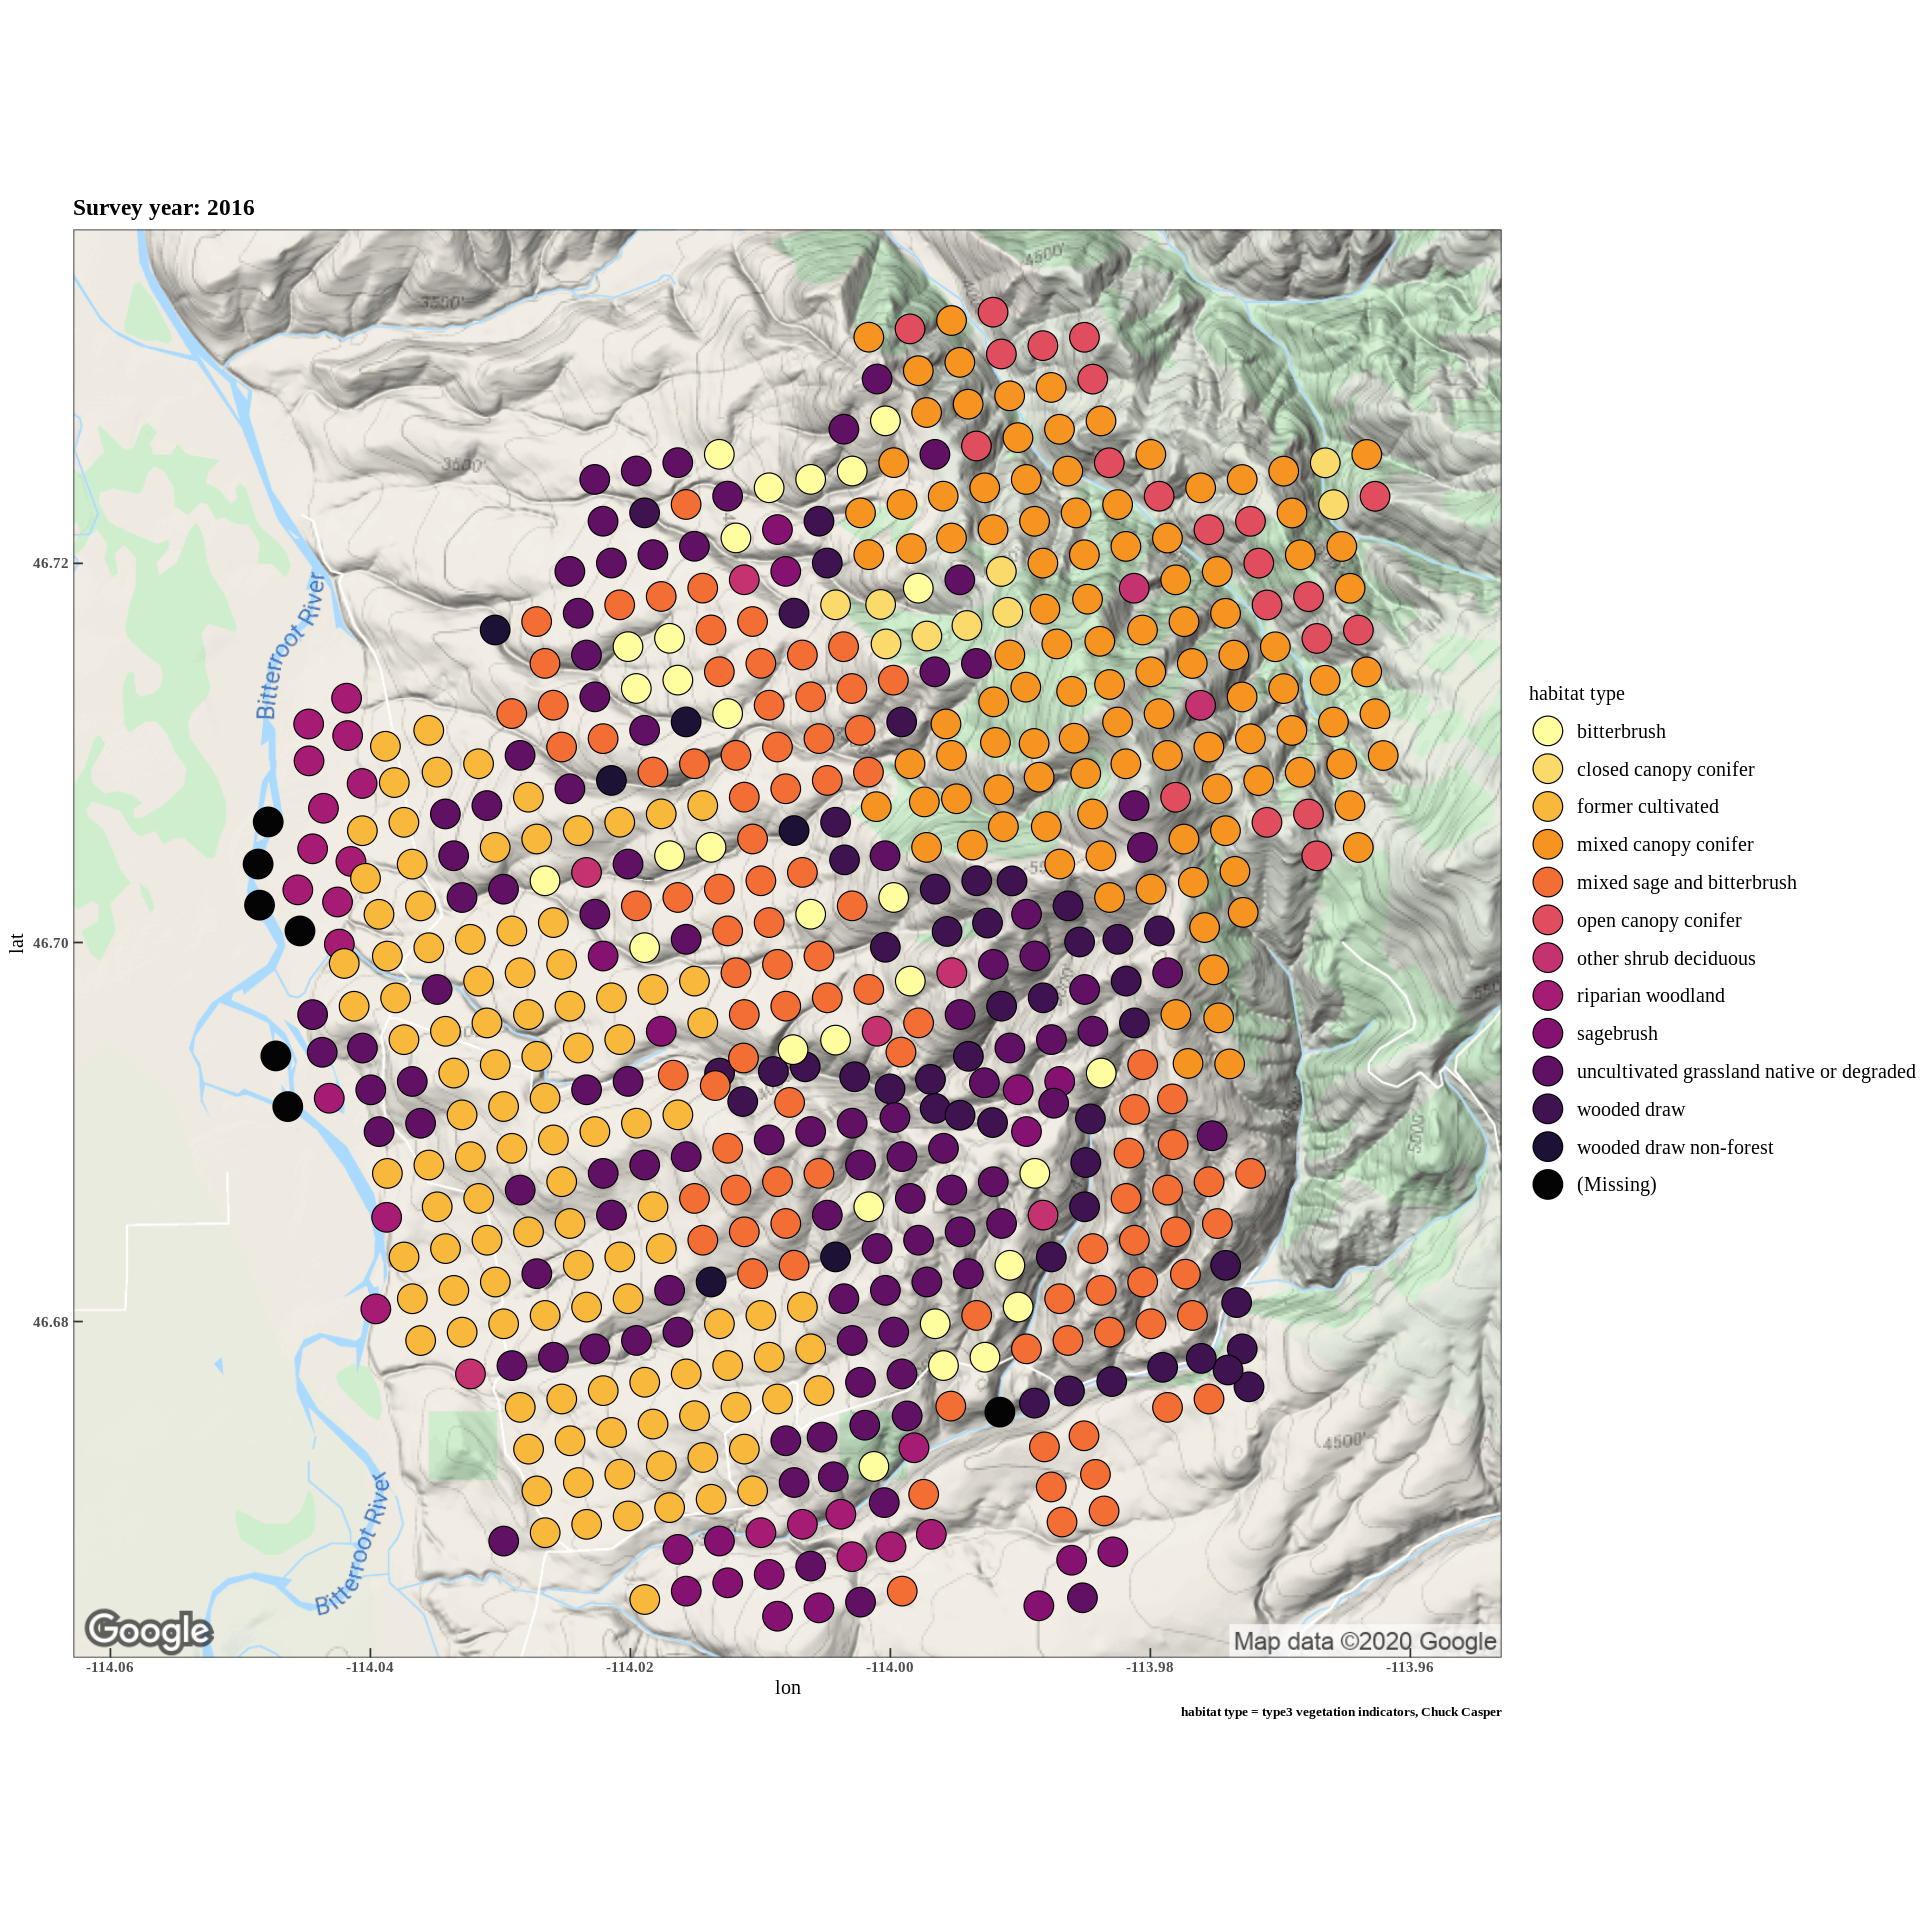

In [0]:
#@title Survey effort maps { run: "auto" }
#@markdown Type a year into the field below. Surveys began in 2010
year <- 2016 #@param {type:"integer"}

# Table of all years' effort
# Produce column sums
func_colsum <- 
function(z) if (is.numeric(z)) {
  sum(z, na.rm = TRUE)
  } else {
  "Total"
  }
survey_table <-
  survey_points_yr %>% 
  group_by(survey_year, type3_vegetation_indicators) %>% 
  summarize(count = n()) %>% 
  spread(survey_year, count) %>% 
  as.data.frame()
survey_table_colsum <-
  survey_points_yr %>% 
  group_by(survey_year, type3_vegetation_indicators) %>% 
  summarize(count = n()) %>% 
  spread(survey_year, count) %>% 
  sapply(., FUN = func_colsum) %>% t() %>% 
  as.data.frame()
rbind(survey_table, survey_table_colsum) %>% 
  kable(format = "pandoc", caption = "Survey effort across years and habitats")

# Plot of selected year
options(repr.plot.width = 16, repr.plot.height = 16)
mpgr_map +
  geom_point(data = survey_points_yr %>% filter(survey_year == year), 
             aes(x = long, y = lat, fill = type3_vegetation_indicators), 
             size = 8, shape = 21) +
  labs(title = paste("Survey year:", year),
       fill = "habitat type",
       caption = "habitat type = type3 vegetation indicators, Chuck Casper") +
  scale_fill_discrete_sequential(palette = "Inferno") +
  theme_bgl


## Bird abundance over time
Should this be called density? 

In [0]:
abundance_order_habitat %>% 
select(-c(5,6)) %>% 
mutate(function_taxa_order = case_when(function_taxa_order == "Accipitriformes" ~ "Raptors",
                                         function_taxa_order == "Falconiformes" ~ "Raptors",
                                         function_taxa_order == "Strigiformes" ~ "Raptors",
                                         TRUE ~ as.character(function_taxa_order))) %>% 
filter(type2_vegetation_community == veg_type,
       function_taxa_order %in% top_taxa) %>% 
complete(nesting(survey_year, survey_grid_point, type1_biome, type2_vegetation_community, type3_vegetation_indicators, type4_indicators_history), 
         function_taxa_order, fill = list(bird_abundance_avg = 0)) %>% 
glimpse()

Rows: 8,661
Columns: 8
$ survey_year                 <int> 2010, 2010, 2010, 2010, 2010, 2010, 2010,…
$ survey_grid_point           <dbl> 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4,…
$ type1_biome                 <chr> "rangeland", "rangeland", "rangeland", "r…
$ type2_vegetation_community  <chr> "grassland", "grassland", "grassland", "g…
$ type3_vegetation_indicators <chr> "uncultivated grassland native or degrade…
$ type4_indicators_history    <chr> "uncultivated grassland native or degrade…
$ function_taxa_order         <chr> "Charadriiformes", "Columbiformes", "Pass…
$ bird_abundance_avg          <dbl> 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0…


Selecting by sum



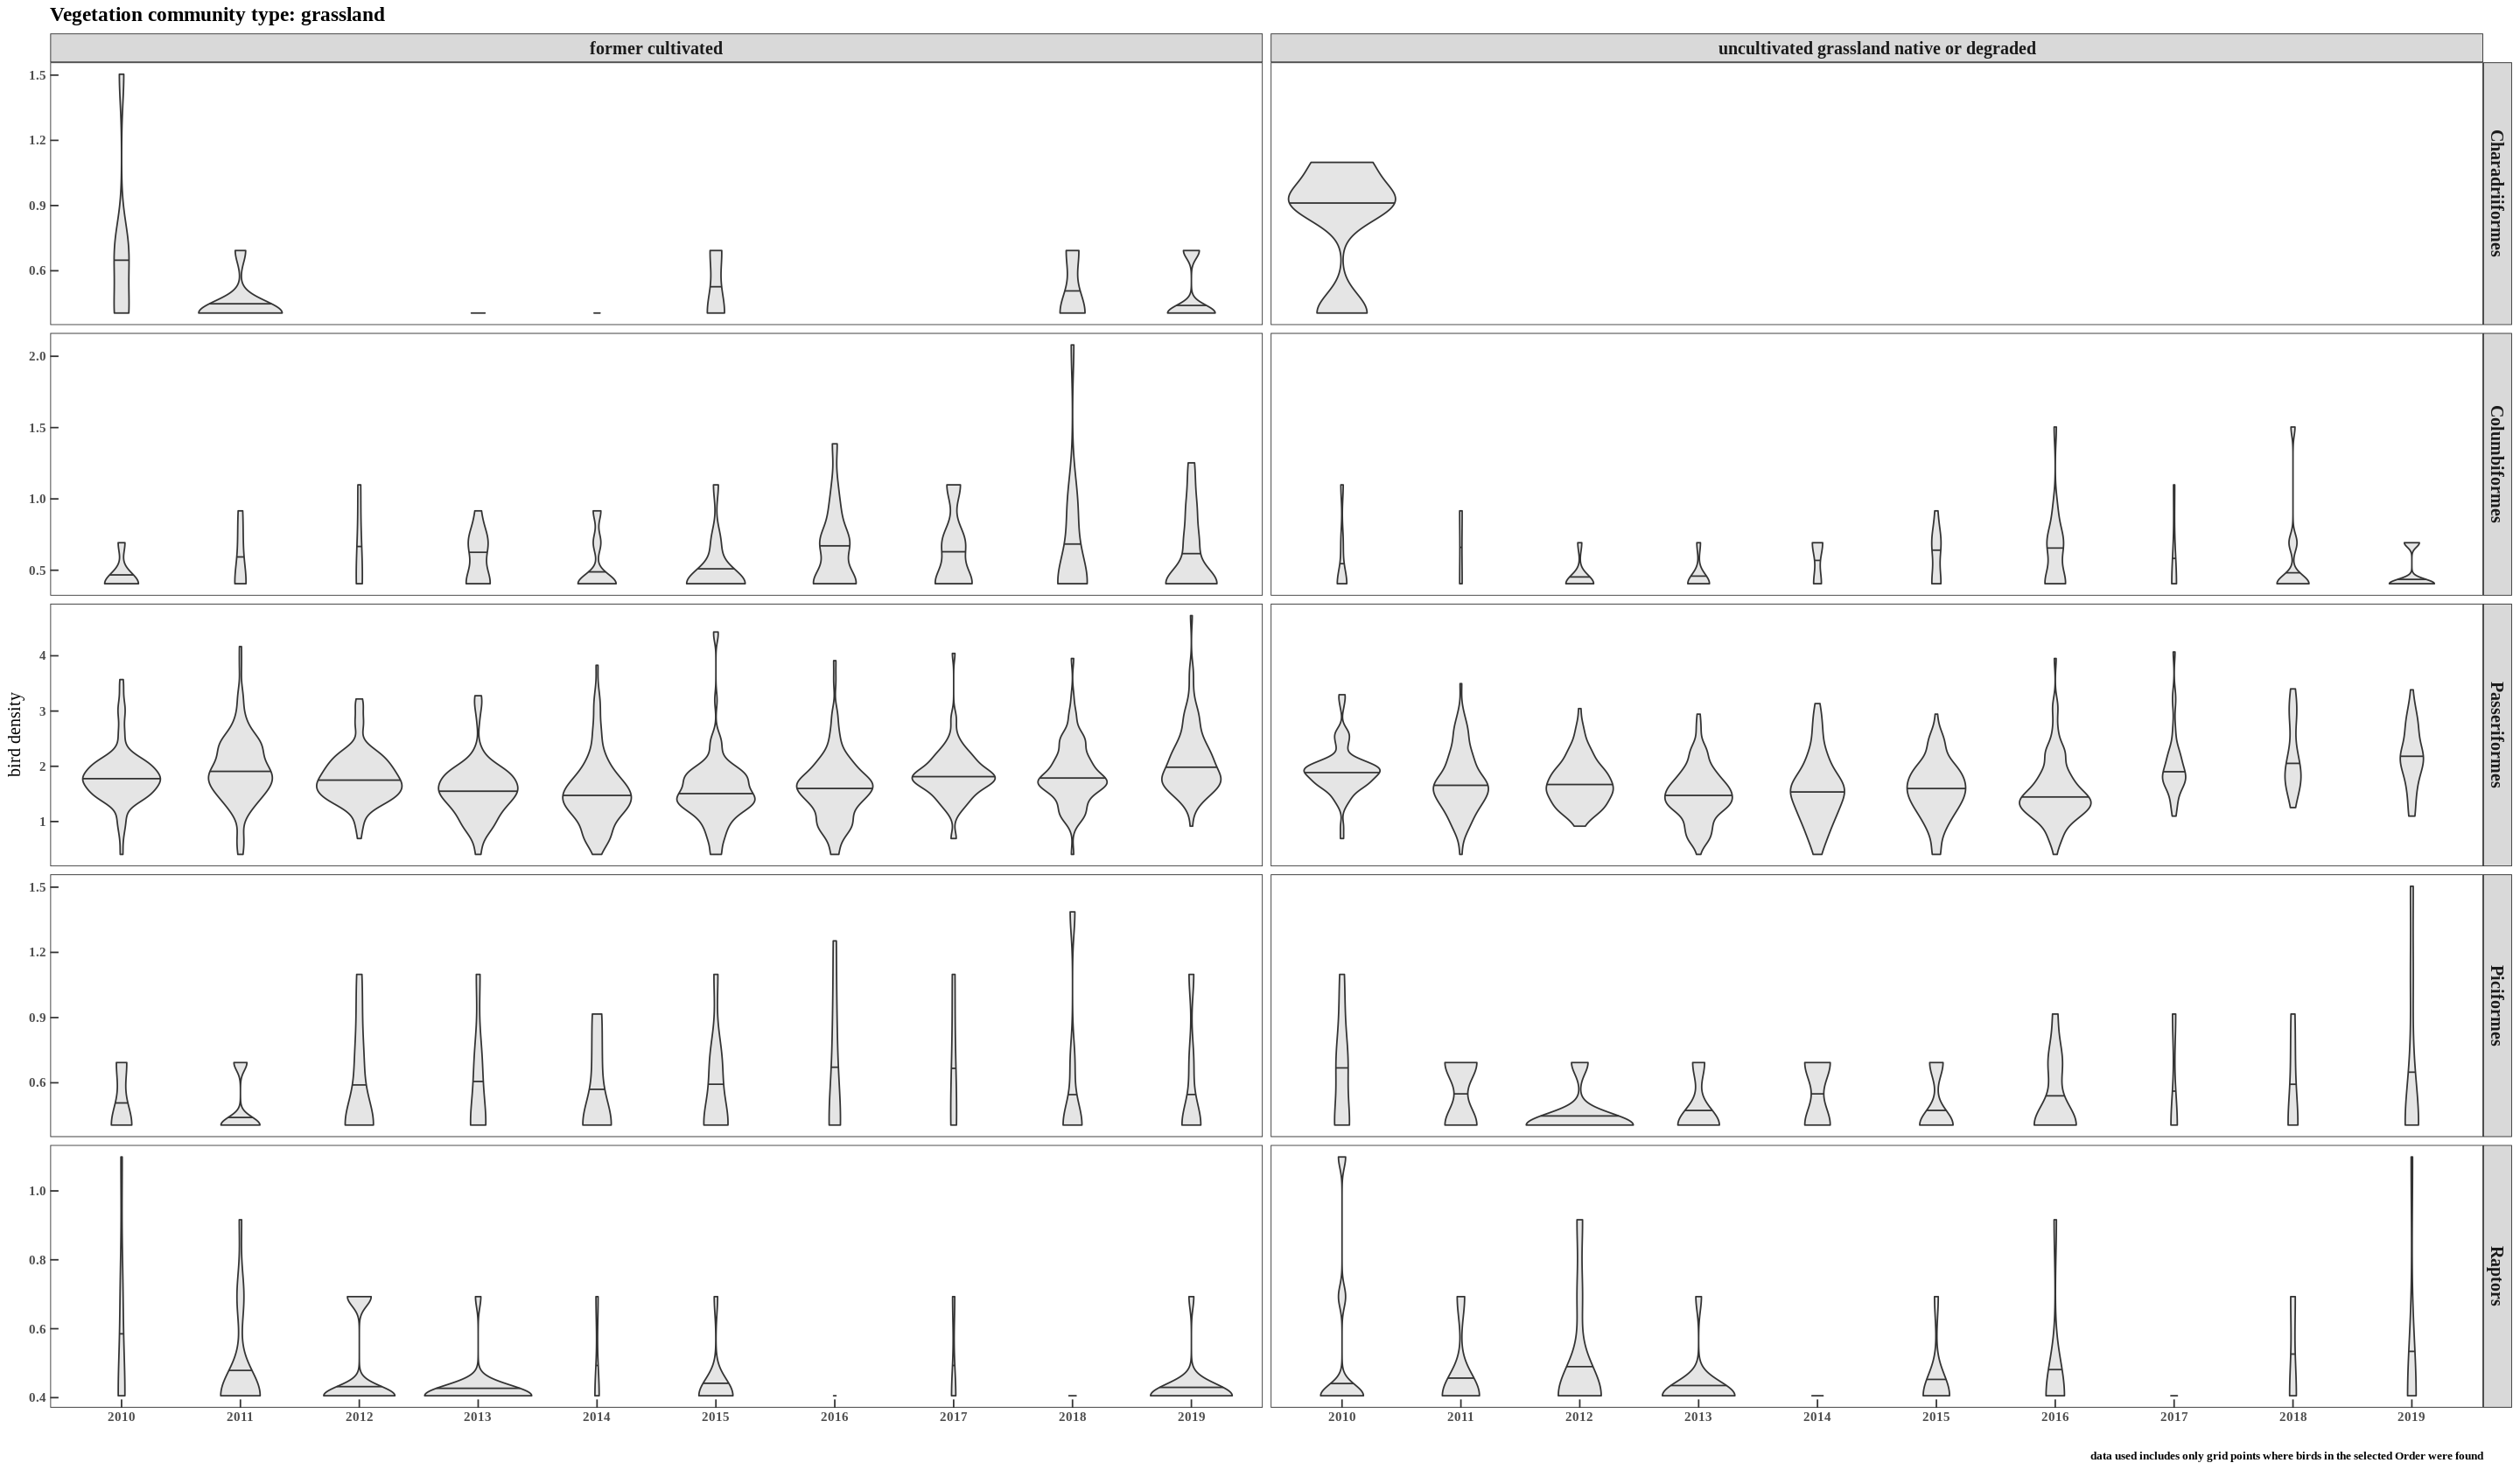

In [0]:
#@title Taxonomic orders: abundance { run: "auto", form-width: "20%" }
#@markdown Choose from the following vegetation community types:
veg_type <- "riparian" #@param ["grassland", "riparian", "shrubland", "upland"]
#@markdown * "Raptors" are not an avian Order, but Orders of predatory birds are grouped 
#@markdown to better show trends
top_taxa <-
  abundance_order_habitat %>% 
  mutate(function_taxa_order = case_when(function_taxa_order == "Accipitriformes" ~ "Raptors",
                                          function_taxa_order == "Falconiformes" ~ "Raptors",
                                          function_taxa_order == "Strigiformes" ~ "Raptors",
                                          TRUE ~ as.character(function_taxa_order))) %>% 
  group_by(function_taxa_order) %>% 
  summarize(sum = sum(bird_abundance_avg, na.rm = TRUE)) %>% 
  top_n(5) %>% 
  pull(function_taxa_order)

options(repr.plot.width = 24, repr.plot.height = 14)
#@markdown * Warnings are generated when zeroes are present in a cell and can safely be ignored
abundance_order_habitat %>% 
select(-c(5,6)) %>% 
mutate(function_taxa_order = case_when(function_taxa_order == "Accipitriformes" ~ "Raptors",
                                         function_taxa_order == "Falconiformes" ~ "Raptors",
                                         function_taxa_order == "Strigiformes" ~ "Raptors",
                                         TRUE ~ as.character(function_taxa_order))) %>% 
filter(type2_vegetation_community == veg_type,
       function_taxa_order %in% top_taxa) %>% 
mutate(survey_year = as.factor(survey_year), bird_abundance_avg_ha = round(bird_abundance_avg * pi, 1)) %>% 
ggplot(aes(x = survey_year, y = log1p(bird_abundance_avg))) +
geom_violin(draw_quantiles = c(0.5), scale = "count", fill = "gray90", na.rm = TRUE) +
facet_grid(rows = vars(function_taxa_order), cols = vars(type3_vegetation_indicators), scales = "free_y") + 
labs(title = paste("Vegetation community type:", veg_type),
     x = "", y = "bird density", 
     fill = "Taxonomic Order",
     caption = "data used includes only grid points where birds in the selected Order were found") +
theme_bgl